In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

In [2]:
# context = pd.read_csv('..//data/preprocessed//context_1217_1230.csv')
context = pd.read_csv('/home/jovyan/df-smart-channel/graph/data/preprocessed/context_1217_0131.csv')

In [3]:
le = LabelEncoder()
context.cust_no = le.fit_transform(context.cust_no)
context.item_id = le.fit_transform(context.item_id)

In [4]:
user_list = context.cust_no.unique()
item_list = context.item_id.unique()

In [5]:
len(user_list)

576702

## Splitting

In [6]:
train_start = 20211217
train_end = 20211225
test_end = 20211226
test_date = test_end

In [7]:
## old version
# def splitting(user_list, train_start, test_date):
#     context_train = context_click[(context_click.date >= train_start) & (context_click.date < test_date)][['cust_no', 'item_id', 'show', 'click']]
#     context_test = context_click[context_click.date == test_date][['cust_no', 'item_id', 'show', 'click']]
    
#     cust_item_pair_train = context_train.groupby(['cust_no', 'item_id'])['click'].sum().reset_index()
#     cust_item_pair_test = context_test.groupby(['cust_no', 'item_id'])['click'].sum().reset_index()
    
#     # cust_item_pair_train = cust_item_pair_train[cust_item_pair_train.click > 0]
#     # cust_item_pair_test = cust_item_pair_test[cust_item_pair_test.click > 0]
    
#     trainUniqueUsers = set(cust_item_pair_train.cust_no.unique())
#     # testUniqueUsers = set(cust_item_pair_test.cust_no.unique())
#     cust_item_pair_test = cust_item_pair_test[cust_item_pair_test.cust_no.isin(trainUniqueUsers)]
    
#     items_by_cust_train = cust_item_pair_train.groupby('cust_no')['item_id'].unique()
#     items_by_cust_test = cust_item_pair_test.groupby('cust_no')['item_id'].unique()
    
#     cust_items_dict_train = dict(items_by_cust_train.apply(list))
#     cust_items_dict_test = dict(items_by_cust_test.apply(list))
#     return cust_items_dict_train, cust_items_dict_test

In [7]:
context_train = context[(context.date >= train_start) & (context.date < test_date)][['cust_no', 'item_id', 'show','click']]
trainUniqueUsers = set(context_train.cust_no.unique())
context_test = context[context.date == test_date][['cust_no', 'item_id','click']]
context_test['is_in_train'] = context_test.cust_no.isin(trainUniqueUsers)
# cust_item_pair_train = context_train.groupby(['cust_no', 'item_id'])['click'].sum().reset_index()
# cust_item_pair_test = context_test.groupby(['cust_no', 'item_id'])['click'].sum().reset_index()

# cust_no = context_test.cust_no.unique()
# init_df = pd.DataFrame({'cust_no': cust_no})

# combined_test = pd.merge(init_df, cust_item_pair_train, on = 'cust_no', how = 'left')[['cust_no', 'item_id']]
# combined_test.item_id = combined_test.item_id.replace(np.nan, -1)

In [9]:
context_test

,cust_no,item_id,click,is_in_train
70,5255,19,0,True
73,5544,19,0,True
84,6330,14,0,True
91,7036,8,0,True
100,7436,14,0,True
...,...,...,...,...
1546474,575491,3,0,True
1546509,120816,10,1,False
1546520,205332,8,1,False
1546529,226528,3,1,True


In [8]:
grouped = context_test.groupby('cust_no')['is_in_train'].mean()
grouped.value_counts()

True     54045
False    20749
Name: is_in_train, dtype: int64

In [116]:
del res

In [12]:
def splitting(user_list, train_start, test_date):
    context_train = context[(context.date >= train_start) & (context.date < test_date)][['cust_no', 'item_id', 'show','click']]
    trainUniqueUsers = set(context_train.cust_no.unique())
    context_test = context[context.date == test_date][['cust_no', 'item_id','click']]
    context_test['is_in_train'] = context_test.cust_no.isin(trainUniqueUsers)
    grouped = context_test.groupby('cust_no')['is_in_train'].mean()
    res = grouped.value_counts()
    return res

In [15]:
res_dict = {}
res_dict['test_date'] = []
res_dict['ncust_in_train'] = []
res_dict['ncust_in_test'] = []
for test_date in range(20211226, 20211231+1):
    res = splitting(user_list = user_list, train_start = 20211217, test_date = test_date)
    res_dict['test_date'].append(test_date)
    res_dict['ncust_in_train'].append(res[1])
    res_dict['ncust_in_test'].append(res[0])
res_df = pd.DataFrame.from_dict(res_dict)
res_df['ncust_total'] = res_df['ncust_in_train'] + res_df['ncust_in_test'] 
res_df['trans_prop'] = res_df['ncust_in_train'] / res_df['ncust_total'] 
    # export_file(date = str(test_date), pairs_dict_train = cust_items_dict_train, pairs_dict_test = cust_items_dict_test )

In [16]:
res_df

,test_date,ncust_in_train,ncust_in_test,ncust_total,trans_prop
0,20211226,54045,20749,74794,0.722585
1,20211227,89054,28281,117335,0.758972
2,20211228,99623,28665,128288,0.776557
3,20211229,98595,25295,123890,0.795827
4,20211230,67880,15082,82962,0.818206
5,20211231,39022,7810,46832,0.833234


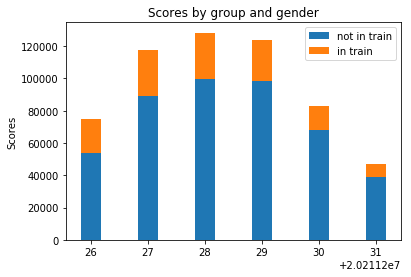

In [17]:
fig, ax = plt.subplots()
width = 0.35
ax.bar(res_df.test_date, res_df.ncust_in_train, width, label='not in train')
ax.bar(res_df.test_date, res_df.ncust_in_test, width, bottom=res_df.ncust_in_train,label='in train')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

In [65]:
def splitting(user_list, train_start, test_date):
    context_train = context[(context.date >= train_start) & (context.date < test_date)][['cust_no', 'item_id', 'show','click']]
    trainUniqueUsers = set(context_train.cust_no.unique())
    context_test = context[context.date == test_date][['cust_no', 'item_id','click']]
    context_test = context_test[context_test.cust_no.isin(trainUniqueUsers)]

    cust_item_pair_train = context_train.groupby(['cust_no', 'item_id'])['click'].sum().reset_index()
    cust_item_pair_test = context_test.groupby(['cust_no', 'item_id'])['click'].sum().reset_index()

    cust_no = context_train.cust_no.unique()
    init_df = pd.DataFrame({'cust_no': cust_no})

    combined_train = pd.merge(init_df, cust_item_pair_train, on = 'cust_no', how = 'left')[['cust_no', 'item_id']]
    # combined_train.item_id = combined_train.item_id.astype(int)
    combined_test = pd.merge(init_df, cust_item_pair_test, on = 'cust_no', how = 'left')[['cust_no', 'item_id']]
    combined_test.item_id = combined_test.item_id.replace(np.nan, -1)
    
    combined_test['not_in_train'] = combined_test.item_id == -1
    grouped = combined_test.groupby('cust_no')['not_in_train'].mean()
    res = grouped.value_counts()
    return res

In [73]:
res_dict = {}
res_dict['test_date'] = []
res_dict['ncust_in_train'] = []
res_dict['ncust_in_test'] = []
for test_date in range(20211226, 20211231+1):
    res = splitting(user_list = user_list, train_start = 20211217, test_date = test_date)
    res_dict['test_date'].append(test_date)
    res_dict['ncust_in_train'].append(res[0])
    res_dict['ncust_in_test'].append(res[1])
res_df = pd.DataFrame.from_dict(res_dict)
    # export_file(date = str(test_date), pairs_dict_train = cust_items_dict_train, pairs_dict_test = cust_items_dict_test )

In [78]:
res_df

,test_date,ncust_in_train,ncust_in_test
0,20211226,54045,396775
1,20211227,89054,382515
2,20211228,99623,400227
3,20211229,98595,429920
4,20211230,67880,485930
5,20211231,39022,529870


In [107]:
res_df

,test_date,ncust_in_train,ncust_in_test
0,20211226,20749,54045
1,20211227,28281,89054
2,20211228,28665,99623
3,20211229,25295,98595
4,20211230,15082,67880
5,20211231,7810,39022


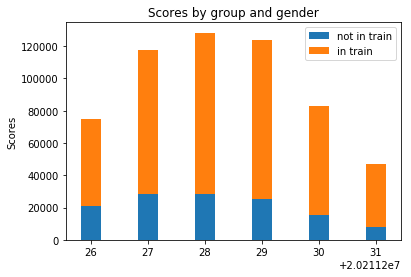

In [106]:
fig, ax = plt.subplots()
width = 0.35
ax.bar(res_df.test_date, res_df.ncust_in_train, width, label='not in train')
ax.bar(res_df.test_date, res_df.ncust_in_test, width, bottom=res_df.ncust_in_train,label='in train')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

In [11]:
test_date = 20211226
cust_items_dict_train, cust_items_dict_test = splitting(user_list = user_list, train_start = 20211217, test_date = test_date) 
# export_file(date = str(test_date), pairs_dict_train = cust_items_dict_train, pairs_dict_test = cust_items_dict_test )
len_tr = len(list(cust_items_dict_train.keys()))
len_te = len(list(cust_items_dict_test.keys()))
print(len_tr)
print(len_te)
print('---')

450820
54045
---


In [9]:
for test_date in range(20211226, 20211231+1):
    cust_items_dict_train, cust_items_dict_test = splitting(user_list = user_list, train_start = 20211217, test_date = test_date) 
    export_file(date = str(test_date), pairs_dict_train = cust_items_dict_train, pairs_dict_test = cust_items_dict_test )
    len_tr = len(list(cust_items_dict_train.keys()))
    len_te = len(list(cust_items_dict_test.keys()))
    print(len_tr)
    print(len_te)
    print('---')

write to file path: <_io.TextIOWrapper name='date=20211226/train.txt' mode='w' encoding='UTF-8'>
450820
write to file path: <_io.TextIOWrapper name='date=20211226/test.txt' mode='w' encoding='UTF-8'>
54045
450820
54045
---
write to file path: <_io.TextIOWrapper name='date=20211227/train.txt' mode='w' encoding='UTF-8'>
471569
write to file path: <_io.TextIOWrapper name='date=20211227/test.txt' mode='w' encoding='UTF-8'>
89054
471569
89054
---
write to file path: <_io.TextIOWrapper name='date=20211228/train.txt' mode='w' encoding='UTF-8'>
499850
write to file path: <_io.TextIOWrapper name='date=20211228/test.txt' mode='w' encoding='UTF-8'>
99623
499850
99623
---
write to file path: <_io.TextIOWrapper name='date=20211229/train.txt' mode='w' encoding='UTF-8'>
528515
write to file path: <_io.TextIOWrapper name='date=20211229/test.txt' mode='w' encoding='UTF-8'>
98595
528515
98595
---
write to file path: <_io.TextIOWrapper name='date=20211230/train.txt' mode='w' encoding='UTF-8'>
553810
writ

In [12]:
# for test_date in range(20211226, 20211231+1):
#     cust_items_dict_train, cust_items_dict_test = splitting(user_list = user_list, train_start = 20211217, test_date = test_date) 
#     len_tr = len(list(cust_items_dict_train.keys()))
#     len_te = len(list(cust_items_dict_test.keys()))
#     print(len_tr)
#     print(len_te)
#     print('---')

8852
50
---
9606
105
---
10964
124
---
12372
114
---
13693
64
---
14486
47
---
